In [2]:
# Import necessary libraries
from fastai.basics import *
from fastai.data.all import *
from fastai.vision.all import *
from fastai.callback.all import *

from fastai.metrics import *
from fastai.callback.wandb import *
from pathlib import Path
import wandb

# New

In [9]:
# Set path to your root directory
path = Path("/scratch/rc4499/masked/chexpert_pn_clean/none")
print(path.ls())

[Path('/scratch/rc4499/masked/chexpert_pn_clean/none/val'), Path('/scratch/rc4499/masked/chexpert_pn_clean/none/train')]


In [10]:
len(get_image_files(path))

12280

In [11]:
data = ImageDataLoaders.from_folder(path, train="train", valid="val",
                                    bs=32, num_workers=2, 
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)],
    item_tfms=None)#
    # item_tfms=RandomCrop(50))
    # item_tfms=Resize(448, method="pad", pad_mode="zeros"))

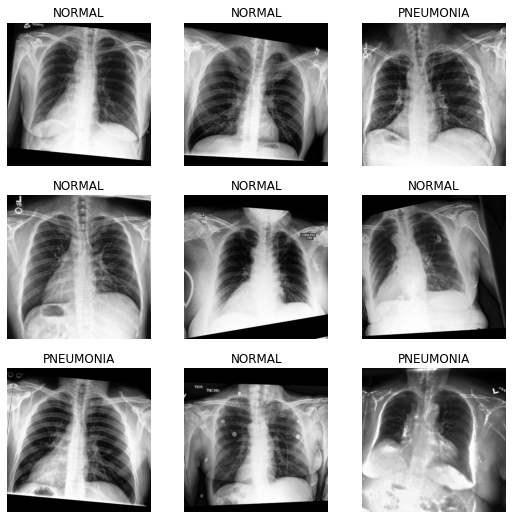

In [12]:
data.show_batch()

In [33]:
# print(len(get_image_files("/scratch/rc4499/pneumonia/imgs/train")),
#       len(get_image_files("/scratch/rc4499/pneumonia/imgs/train/NORMAL")),
#       len(get_image_files("/scratch/rc4499/pneumonia/imgs/train/PNEUMONIA")))

# data = ImageDataLoaders.from_folder("/scratch/rc4499/pneumonia/imgs/train", valid_pct=0.5, bs=32, num_workers=2, 
#     batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)],
# #    item_tfms=Resize(224))
#     item_tfms=Resize(448, method="pad", pad_mode="zeros"))

orig_ys = np.array([0, 0])
# orig_ys = {"nih":0, "chexpert":0}
for item in data.train_ds:
    y = item[1]
    val = y.item()
    orig_ys[val] += 1
    
for item in data.valid_ds:
    y = item[1]
    val = y.item()
    orig_ys[val] += 1
    
print(orig_ys)

[1000 1000]


In [14]:
run = wandb.init(project="ml4h",
        name="lr_find_pneumonia_check",
        job_type="lr_find")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: basedrhys (use `wandb login --relogin` to force relogin)


In [13]:
# Build the CNN model with the pretrained resnet34
learn = cnn_learner(data, models.resnet50, metrics = [accuracy, F1Score(), RocAucBinary(), Precision(), Recall()]) #,cbs=[WandbCallback(), SaveModelCallback()])
# learn = cnn_learner(data, models.resnet50, metrics = [accuracy, F1Score(), RocAucBinary(), s], cbs=None)

SuggestedLRs(valley=0.00013182566908653826)

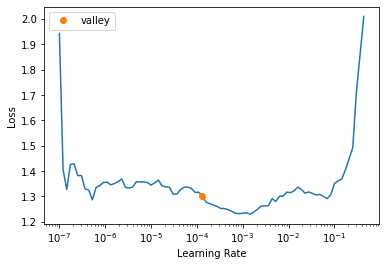

In [14]:
learn.lr_find()

In [7]:
run = wandb.init(project="ml4h",
        name="train_pneumonia_convex_hull",
        job_type="train")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: basedrhys (use `wandb login --relogin` to force relogin)


In [9]:
# Train the model on 4 epochs of data at the default learning rate
# Ignore error rate/valid loss data here, decreasing train loss is all that matters
learn.fit_one_cycle(5, lr_max=3e-4)

epoch,train_loss,valid_loss,accuracy,f1_score,roc_auc_score,precision_score,recall_score,time
0,0.671885,0.418692,0.861775,0.889796,0.951500,0.970326,0.821608,00:58
1,0.452211,0.315783,0.906143,0.927727,0.966374,0.972452,0.886935,00:55
2,0.333001,0.296866,0.931741,0.948187,0.968179,0.978610,0.919598,00:55
3,0.255474,0.274983,0.924915,0.942408,0.974714,0.983607,0.904523,00:55
4,0.250045,0.268920,0.930034,0.946545,0.975663,0.983740,0.912060,00:55


Better model found at epoch 0 with valid_loss value: 0.41869232058525085.
Better model found at epoch 1 with valid_loss value: 0.3157830834388733.
Better model found at epoch 2 with valid_loss value: 0.29686570167541504.
Better model found at epoch 3 with valid_loss value: 0.2749827802181244.
Better model found at epoch 4 with valid_loss value: 0.26892000436782837.


In [10]:
filename = "pneumonia-convexhull-model"
save_path = learn.save(f"/home/rc4499/models/{filename}")
save_path
# learn.load(filename)

Path('/home/rc4499/models/pneumonia-convexhull-model.pth')

In [52]:
interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_top_losses(k=2)

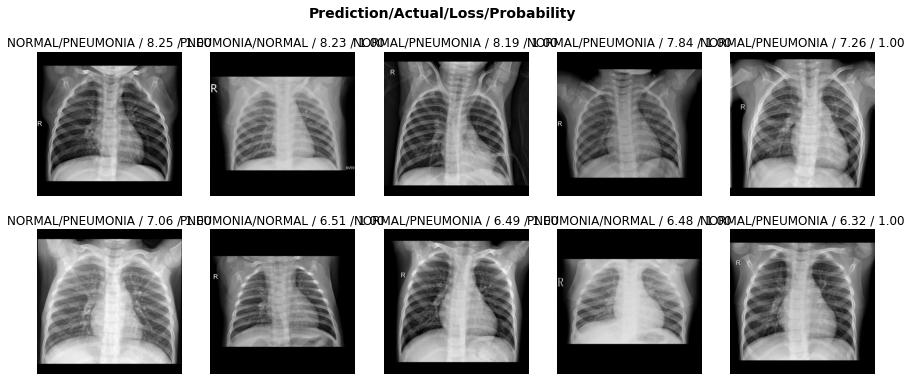

In [ ]:
def plot_top_losses_fix(interp, k, largest=True, **kwargs):
    losses,idx = interp.top_losses(k, largest)
    if not isinstance(interp.inputs, tuple): interp.inputs = (interp.inputs,)
    if isinstance(interp.inputs[0], Tensor): inps = tuple(o[idx] for o in interp.inputs)
    else: inps = interp.dl.create_batch(interp.dl.before_batch([tuple(o[i] for o in interp.inputs) for i in idx]))
    b = inps + tuple(o[idx] for o in (interp.targs if is_listy(interp.targs) else (interp.targs,)))
    x,y,its = interp.dl._pre_show_batch(b, max_n=k)
    b_out = inps + tuple(o[idx] for o in (interp.decoded if is_listy(interp.decoded) else (interp.decoded,)))
    x1,y1,outs = interp.dl._pre_show_batch(b_out, max_n=k)
    if its is not None:
        #plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), L(self.preds).itemgot(idx), losses,  **kwargs)
        plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), interp.preds[idx], losses,  **kwargs)
    #TODO: figure out if this is needed
    #its None means that a batch knows how to show itself as a whole, so we pass x, x1
    #else: show_results(x, x1, its, ctxs=ctxs, max_n=max_n, **kwargs)
plot_top_losses_fix(interp, 10, nrows=2)

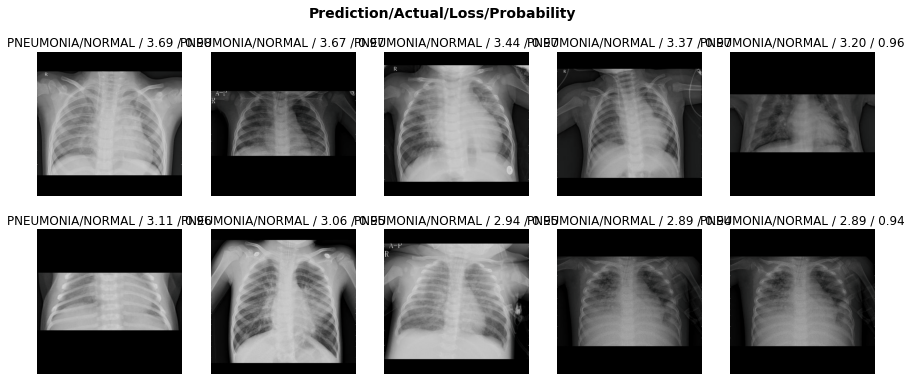

In [53]:
# Masked
plot_top_losses_fix(interp, 10, nrows=2)

In [11]:
model_artifact = wandb.Artifact('model', type='model')
model_artifact.add_file(save_path)
wandb.run.log_artifact(model_artifact)

In [12]:
wandb.finish()

wandb: Network error (ConnectTimeout), entering retry loop.
wandb: Network error (ConnectTimeout), entering retry loop.
wandb: Network error (ConnectTimeout), entering retry loop.
wandb: Network error (ConnectTimeout), entering retry loop.
wandb: Network error (ConnectTimeout), entering retry loop.
wandb: Network error (ConnectTimeout), entering retry loop.
wandb: Network error (ConnectTimeout), entering retry loop.
wandb: Network error (ConnectTimeout), entering retry loop.
wandb: Network error (ConnectTimeout), entering retry loop.
wandb: Network error (ConnectTimeout), entering retry loop.
wandb: Network error (ConnectTimeout), entering retry loop.
wandb: Network error (ConnectTimeout), entering retry loop.
wandb: Network error (ConnectTimeout), entering retry loop.
wandb: Network error (ConnectTimeout), entering retry loop.
wandb: Network error (ConnectTimeout), entering retry loop.
wandb: Network error (ConnectTimeout), entering retry loop.
wandb: Network error (ConnectTimeout), e

# Evaluate On Test Set

In [ ]:
test_path = root_path/"imgs"

test_imgs = get_image_files(img_path)
test_imgs.sort()
test_imgs

In [10]:
preds = learn.get_preds(ds_type=DatasetType.Valid)

NameError: name 'DatasetType' is not defined

# Hospital Systems

In [5]:
# Set path to your root directory
path = Path('/scratch/rc4499/hospital_systems')
print(path.ls())

[Path('/scratch/rc4499/hospital_systems/chexpert'), Path('/scratch/rc4499/hospital_systems/models'), Path('/scratch/rc4499/hospital_systems/nih'), Path('/scratch/rc4499/hospital_systems/iu')]


/ext3/miniconda3/envs/ml4h/lib/python3.7/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272178570/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


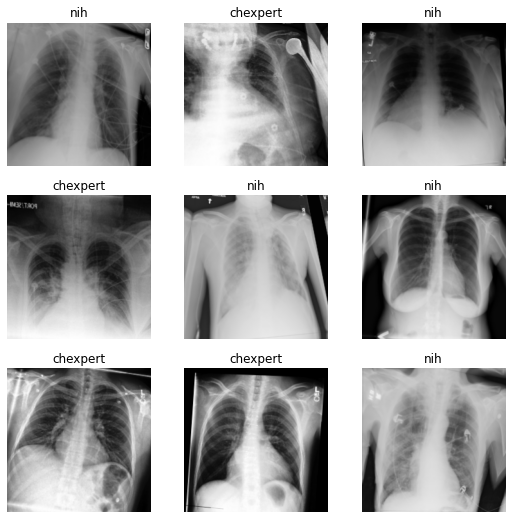

In [6]:
data = ImageDataLoaders.from_folder(path, valid_pct=0.2, seed=42, bs=128, num_workers=2, 
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)],
    item_tfms=Resize(224))

data.show_batch()

In [7]:
wandb.init(project="ml4h",
        name="lr_find_hospital_systems_none",
        job_type="lr_find")

wandb: Currently logged in as: basedrhys (use `wandb login --relogin` to force relogin)


In [13]:
my_metrics = [
    accuracy,
    F1Score(average="weighted"),
    RocAuc(average="dfsdf")
]

In [8]:
# Build the CNN model with the pretrained resnet34
learn = cnn_learner(data, models.resnet50, 
                    metrics = [accuracy, F1Score(), RocAuc()], 
                    cbs=[WandbCallback(), SaveModelCallback()])

SuggestedLRs(valley=0.0004786300996784121)

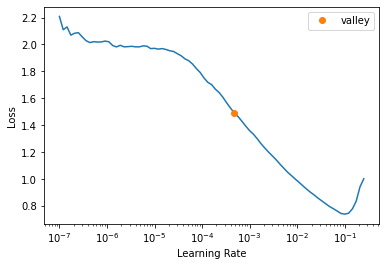

In [9]:
learn.lr_find()

In [10]:
run = wandb.init(project="ml4h",
        name="train_hospital_systems_none",
        job_type="train")

In [11]:
# Train the model on 4 epochs of data at the default learning rate
# Ignore error rate/valid loss data here, decreasing train loss is all that matters
learn.fit_one_cycle(15, lr_max=3e-4)

epoch,train_loss,valid_loss,accuracy,f1_score,roc_auc_score,time


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

## Clear Memory

In [ ]:
import gc
learn = None
data = None
gc.collect()
torch.cuda.empty_cache()